<a href="https://colab.research.google.com/github/csoren66/Buyers_Time_Prediction/blob/main/Buyers_Time_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [2]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import pandas as pd
import re
import gc
import numpy as np
import math
from catboost import CatBoostRegressor
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_squared_log_error,make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge,RidgeCV,BayesianRidge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import math
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS
stopwords1 = set(STOPWORDS)
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from scipy.sparse import csr_matrix
from scipy import sparse
import scipy
from sklearn.linear_model import Ridge
%matplotlib inline

In [3]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords1,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
        ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [6]:
train = pd.read_csv('/content/Train.csv')
test = pd.read_csv('/content/Test.csv')
sample = pd.read_csv('/content/Sample Submission.csv')

In [7]:
train.shape, test.shape

((5429, 9), (2327, 8))

In [8]:
train.head()

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent
0,57f879e70d3c5fc2a98102d64c9fd84e,715,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2020-01-22,1,0,0,236.886
1,a5442b0c7c33d0a811e7661e556b2de8,55,Product/8.0 iPhone/8.1.3,iPhone - iOS,2020-02-27,1,0,0,1277.455
2,305cb1486ed8610c00b37007926cb2c4,11,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like ...,iPhone - MobileWeb,2019-08-01,0,0,0,21.704
3,f2c1ecc9993f0071df91ba178450498c,2794,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Desktop - IE,2019-12-30,0,1,0,455.201
4,e460830ae295e55d2216ebdc761ab9a6,3674,Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_1 like ...,iPhone - Web,2019-09-10,0,0,0,1164.877


In [9]:
test.columns

Index(['session_id', 'session_number', 'client_agent', 'device_details',
       'date', 'purchased', 'added_in_cart', 'checked_out'],
      dtype='object')

#Feature Engineering

In [10]:
dataset = pd.concat([train, test])
dataset = dataset.reset_index(drop = True)

dataset = dataset.sort_values(by=['session_id'])

dataset["client_agent_length"] = dataset["client_agent"].str.len()

dataset["client_agent_semicolon_count"] = dataset["client_agent"].str.count(";")

dataset["client_agent_version_count"] = dataset["client_agent"].str.count("/")

dataset["browser_version"] = dataset["client_agent"].str.split("/",expand=True)[1].str.split(" ",expand=True)[0]

dataset [["device","browser"]] = dataset["device_details"].str.split(pat=" - ",expand=True)

handheld = [int(i in ["iPhone","Android Phone","Android Tablet","iPad"]) for i in dataset ["device"]]
dataset ["hand_held"] = pd.Series(handheld)

desktop = [int(i == "Desktop") for i in dataset ["device"]]
dataset ["desktop"] = pd.Series(desktop)

others = [int(i in ["Other","Unknown"]) for i in dataset["device"]]
dataset["others"] = pd.Series(others)


dataset["overallScore"] = dataset["purchased"]*0.9820073158772702 + dataset["added_in_cart"]*1 + dataset["checked_out"]*1.816082409501863


dataset['date']= pd.to_datetime(dataset['date'])

dataset["month"] = dataset['date'].dt.month
dataset["year"] = dataset['date'].dt.year
dataset["week"] = dataset['date'].dt.week
dataset["dayOfWeek"] = dataset['date'].dt.dayofweek
dataset["day"] = dataset["date"].dt.day


dataset["dailyTraffic"] = dataset.groupby("date")["session_id"].transform("count")

dataset["dailyTrafficPerDevice"] = dataset.groupby(["date","device"])["session_id"].transform("count")
dataset["dailyTrafficPerbrowser"] = dataset.groupby(["date","browser"])["session_id"].transform("count")



dataset["device_num"] = dataset["device"].replace({"Other": 1, "Unknown": 1, 
                         "Android Tablet":2,
                        "iPhone":3,
                        "Android Phone":4,
                        "iPad":5, "Desktop":5})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [11]:
dataset

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent,client_agent_length,...,overallScore,month,year,week,dayOfWeek,day,dailyTraffic,dailyTrafficPerDevice,dailyTrafficPerbrowser,device_num
3696,0000ccfee64caa1d4ac5e2c025183bd5,77,Product/4.2.2 iPhone/7.1.2,iPhone - iOS,2019-10-07,1,0,0,175.537,26.0,...,0.982007,10,2019,41,0,7,22,11,9,3
111,0001351371faa5a11668bd7e595d718b,33,Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7....,Desktop - IE,2020-02-28,1,0,0,849.612,68.0,...,0.982007,2,2020,9,4,28,17,8,2,5
2777,00061e9b19af901ed6172af75447e0fe,220,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,Desktop - Chrome,2020-02-22,0,0,0,40.830,102.0,...,0.000000,2,2020,8,5,22,26,11,7,5
5933,0007570f57deb464f48e062d9751cb95,3344,Product/4.7.0 iPhone/8.1,iPhone - iOS,2019-12-26,0,1,0,NaN,24.0,...,1.000000,12,2019,52,3,26,29,22,14,3
5204,0007799644b7b1eec55a6390deda8065,143,Product/4.1.1 iPhone/7.1.2,iPhone - iOS,2019-08-11,0,0,0,1046.787,26.0,...,0.000000,8,2019,32,6,11,30,12,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896,ffdb27513dc4b81f146371ec20aa8196,187,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)...,Desktop - Chrome,2020-01-16,0,0,0,83.061,119.0,...,0.000000,1,2020,3,3,16,19,10,4,5
6834,ffdc0c7c301ab9528d0efc5e2435d4de,627,Product/4.6.0 iPhone/8.1,iPhone - iOS,2019-11-26,0,0,0,NaN,24.0,...,0.000000,11,2019,48,1,26,42,21,14,3
4702,ffde54e480e73edafefb3eecd209e66a,3212,Mozilla/5.0 (iPhone; CPU iPhone OS 8_1_2 like ...,iPhone - Web,2019-12-24,0,0,0,22.077,109.0,...,0.000000,12,2019,52,1,24,42,22,11,3
7267,ffe0e1239bf610cd92b6769fd284bc8c,1485,Product/4.1.1 iPhone/7.0.2,iPhone - iOS,2019-09-04,0,0,0,NaN,26.0,...,0.000000,9,2019,36,2,4,32,21,10,3


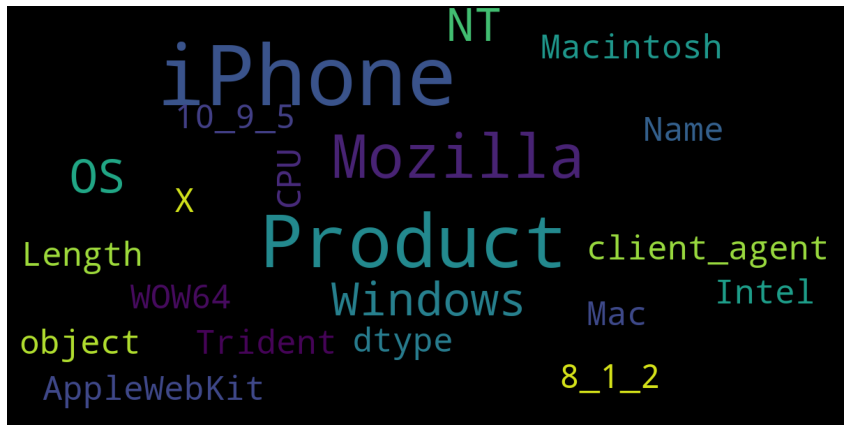

In [12]:
show_wordcloud(dataset['client_agent'])

In [13]:
dataset.isnull().sum()

session_id                         0
session_number                     0
client_agent                     219
device_details                     0
date                               0
purchased                          0
added_in_cart                      0
checked_out                        0
time_spent                      2327
client_agent_length              219
client_agent_semicolon_count     219
client_agent_version_count       219
browser_version                  229
device                             0
browser                            0
hand_held                          0
desktop                            0
others                             0
overallScore                       0
month                              0
year                               0
week                               0
dayOfWeek                          0
day                                0
dailyTraffic                       0
dailyTrafficPerDevice              0
dailyTrafficPerbrowser             0
d

In [16]:
dataset["client_agent"] = dataset["client_agent"].fillna('n/a')
dataset['client_agent_length'] = dataset['client_agent_length'].fillna(0)
dataset['client_agent_semicolon_count'] = dataset['client_agent_semicolon_count'].fillna(0)
dataset['client_agent_version_count'] = dataset['client_agent_version_count'].fillna(0)
dataset['browser_version'] = dataset['browser_version'].fillna('n/a')

In [17]:
dataset.isnull().sum()

session_id                         0
session_number                     0
client_agent                       0
device_details                     0
date                               0
purchased                          0
added_in_cart                      0
checked_out                        0
time_spent                      2327
client_agent_length                0
client_agent_semicolon_count       0
client_agent_version_count         0
browser_version                    0
device                             0
browser                            0
hand_held                          0
desktop                            0
others                             0
overallScore                       0
month                              0
year                               0
week                               0
dayOfWeek                          0
day                                0
dailyTraffic                       0
dailyTrafficPerDevice              0
dailyTrafficPerbrowser             0
d

In [18]:
dataset

,session_id,session_number,client_agent,device_details,date,purchased,added_in_cart,checked_out,time_spent,client_agent_length,...,month,year,week,dayOfWeek,day,dailyTraffic,dailyTrafficPerDevice,dailyTrafficPerbrowser,device_num,client_semicolon_count
3696,0000ccfee64caa1d4ac5e2c025183bd5,77,Product/4.2.2 iPhone/7.1.2,iPhone - iOS,2019-10-07,1,0,0,175.537,26.0,...,10,2019,41,0,7,22,11,9,3,0.0
111,0001351371faa5a11668bd7e595d718b,33,Mozilla/5.0 (Windows NT 6.3; WOW64; Trident/7....,Desktop - IE,2020-02-28,1,0,0,849.612,68.0,...,2,2020,9,4,28,17,8,2,5,3.0
2777,00061e9b19af901ed6172af75447e0fe,220,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,Desktop - Chrome,2020-02-22,0,0,0,40.830,102.0,...,2,2020,8,5,22,26,11,7,5,0.0
5933,0007570f57deb464f48e062d9751cb95,3344,Product/4.7.0 iPhone/8.1,iPhone - iOS,2019-12-26,0,1,0,NaN,24.0,...,12,2019,52,3,26,29,22,14,3,0.0
5204,0007799644b7b1eec55a6390deda8065,143,Product/4.1.1 iPhone/7.1.2,iPhone - iOS,2019-08-11,0,0,0,1046.787,26.0,...,8,2019,32,6,11,30,12,6,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896,ffdb27513dc4b81f146371ec20aa8196,187,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)...,Desktop - Chrome,2020-01-16,0,0,0,83.061,119.0,...,1,2020,3,3,16,19,10,4,5,1.0
6834,ffdc0c7c301ab9528d0efc5e2435d4de,627,Product/4.6.0 iPhone/8.1,iPhone - iOS,2019-11-26,0,0,0,NaN,24.0,...,11,2019,48,1,26,42,21,14,3,0.0
4702,ffde54e480e73edafefb3eecd209e66a,3212,Mozilla/5.0 (iPhone; CPU iPhone OS 8_1_2 like ...,iPhone - Web,2019-12-24,0,0,0,22.077,109.0,...,12,2019,52,1,24,42,22,11,3,1.0
7267,ffe0e1239bf610cd92b6769fd284bc8c,1485,Product/4.1.1 iPhone/7.0.2,iPhone - iOS,2019-09-04,0,0,0,NaN,26.0,...,9,2019,36,2,4,32,21,10,3,0.0


In [19]:
dataset.corr().style.background_gradient(cmap = 'coolwarm')

,session_number,purchased,added_in_cart,checked_out,time_spent,client_agent_length,client_agent_semicolon_count,client_agent_version_count,hand_held,desktop,others,overallScore,month,year,week,dayOfWeek,day,dailyTraffic,dailyTrafficPerDevice,dailyTrafficPerbrowser,device_num,client_semicolon_count
session_number,1.000000,-0.219457,0.004128,-0.062982,0.078437,-0.165386,-0.064838,-0.223878,0.009673,0.001579,-0.024570,-0.145082,0.074655,0.010379,0.070730,0.006846,0.011354,0.233520,0.360082,0.281476,-0.261315,-0.064838
purchased,-0.219457,1.000000,0.044784,0.176573,0.200762,0.058624,0.008766,0.069010,0.009756,-0.013197,0.006470,0.655528,-0.052782,0.057537,-0.058860,-0.005721,-0.015375,-0.072491,-0.116730,-0.101803,0.272977,0.008766
added_in_cart,0.004128,0.044784,1.000000,0.213134,0.209807,-0.022542,0.061586,-0.014826,-0.003176,0.006424,-0.006603,0.686999,-0.043921,0.050055,-0.041419,-0.036994,0.009440,-0.020105,-0.052343,-0.008336,0.122896,0.061586
checked_out,-0.062982,0.176573,0.213134,1.000000,0.157765,0.039280,0.009152,0.030195,-0.000463,0.001043,-0.001188,0.607178,-0.009714,0.013095,-0.011682,0.002739,-0.003550,0.002734,-0.019611,-0.026521,0.108779,0.009152
time_spent,0.078437,0.200762,0.209807,0.157765,1.000000,-0.025433,-0.032025,-0.002716,0.017945,-0.012565,-0.012850,0.295618,0.013367,-0.030843,0.008201,0.000285,-0.030206,0.070030,0.110008,0.075365,0.069221,-0.032025
client_agent_length,-0.165386,0.058624,-0.022542,0.039280,-0.025433,1.000000,0.487803,0.805970,0.016501,-0.014498,-0.005589,0.034955,0.021760,0.020808,0.022520,0.011551,-0.000117,-0.038244,-0.137149,-0.267861,0.488898,0.487803
client_agent_semicolon_count,-0.064838,0.008766,0.061586,0.009152,-0.032025,0.487803,1.000000,0.240019,0.002116,0.000528,-0.005762,0.044157,-0.025034,0.014729,-0.021789,0.008510,0.032465,-0.065582,-0.167893,-0.214668,0.179135,1.000000
client_agent_version_count,-0.223878,0.069010,-0.014826,0.030195,-0.002716,0.805970,0.240019,1.000000,0.001257,-0.003139,0.003875,0.041770,-0.012701,0.066701,-0.018576,-0.001999,-0.015227,-0.039320,-0.183889,-0.218464,0.440171,0.240019
hand_held,0.009673,0.009756,-0.003176,-0.000463,0.017945,0.016501,0.002116,0.001257,1.000000,-0.892929,-0.308381,0.003460,0.000843,-0.007321,-0.000389,0.002573,0.006140,-0.019303,-0.005656,-0.006677,-0.002049,0.002116
desktop,0.001579,-0.013197,0.006424,0.001043,-0.012565,-0.014498,0.000528,-0.003139,-0.892929,1.000000,-0.152893,-0.003286,-0.001369,0.007840,0.000826,-0.000835,0.003318,0.019249,0.014348,0.014723,0.007749,0.000528


In [23]:
dataset=pd.get_dummies(dataset,columns=['device_num','browser_version'],drop_first=True)

In [26]:
fin_features = list(set(dataset.columns) - set(["session_id","client_agent","date","device","browser","device_details","time_spent","index"]))
fin_features

['browser_version_150297',
 'browser_version_160309',
 'device_num_5',
 'browser_version_7.0',
 'dailyTrafficPerDevice',
 'browser_version_4.1.1',
 'browser_version_3.0.1',
 'hand_held',
 'browser_version_160379',
 'browser_version_160393',
 'browser_version_252',
 'added_in_cart',
 'browser_version_160360',
 'browser_version_160432',
 'browser_version_n/a',
 'year',
 'browser_version_6533.21.1',
 'browser_version_150261',
 'browser_version_214',
 'browser_version_9.80',
 'dailyTraffic',
 'browser_version_3.2.1',
 'browser_version_150287',
 'browser_version_160341',
 'browser_version_160326',
 'browser_version_150264',
 'browser_version_160441',
 'browser_version_160333',
 'session_number',
 'desktop',
 'browser_version_4.7.0',
 'browser_version_160362',
 'browser_version_3.4.0',
 'client_agent_length',
 'others',
 'month',
 'browser_version_3.3.1',
 'checked_out',
 'browser_version_245',
 'browser_version_4.5.0',
 'browser_version_160406',
 'browser_version_160346',
 'browser_version_

In [27]:
dftrain, dftest  = dataset[dataset["time_spent"].isnull()==False], dataset[dataset["time_spent"].isnull()==True]
dftest.reset_index(drop=True, inplace=True)
target = np.log1p(dftrain['time_spent'])

In [29]:
 #TF-IDF
v_1 = TfidfVectorizer(ngram_range=(1,3),stop_words="english", analyzer='word')
typ_tr =v_1.fit_transform(dftrain['client_agent'])
typ_ts =v_1.transform(dftest['client_agent'])


v_1c = TfidfVectorizer(ngram_range=(2,6),stop_words="english", analyzer='char')
typ_trc =v_1c.fit_transform(dftrain['client_agent'])
typ_tsc =v_1c.transform(dftest['client_agent'])

In [31]:
final_features = sparse.hstack((dftrain[fin_features],typ_tr,typ_trc)).tocsr()
final_featurest = sparse.hstack((dftest[fin_features],typ_ts ,typ_tsc)).tocsr()

In [32]:
#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(real, predicted):
    real=np.expm1(real)
    predicted=np.expm1(predicted)
    return np.sqrt(mean_squared_log_error(real,predicted))
    

def rmsle_lgb(labels, preds):
    return 'rmsle', rmsle(preds,labels), False

In [33]:
X_trn, X_val, y_trn, y_val = train_test_split(final_features, target, test_size=0.25, random_state=1996)
X_test = final_featurest

#LightGBM

In [34]:
def learning_rate_010_decay_power_0995(current_iter): 
    base_learning_rate = 0.0009
    lr = base_learning_rate * np.power(.995, current_iter) 
    return lr if lr > 1e-4 else 1e-4

In [36]:
X=final_features
y=target

y_pred_tot=[]
err=[]
feature_importance_df = pd.DataFrame()

#For Stacking
lgbm_train_res = pd.DataFrame()
lgbm_test_res = pd.DataFrame()

from sklearn.model_selection import KFold,StratifiedKFold
fold=KFold(n_splits=4,shuffle=True,random_state=1996)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    depth=10
    m=LGBMRegressor(n_estimators=2000,n_jobs=-1,learning_rate=0.005,max_depth=depth,num_leaves=2**depth-1)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=200,verbose=200,eval_metric="rmse")
    preds=m.predict(X_test,num_iteration=m.best_iteration_)
    #print(f"RMSLE is:",rmsle_lgb(y_test, preds))
    print(f"RMSLE is: {np.sqrt(mean_squared_log_error(np.expm1(y_test), np.expm1(preds)))}")
    err.append(np.sqrt(mean_squared_log_error(np.expm1(y_test), np.expm1(preds))))
    p = m.predict(final_featurest)
    y_pred_tot.append(p)
    
    lgbm_train_res["iteration_"+str(i)] = m.predict(X)
    lgbm_test_res["iteration_"+str(i)] = m.predict(final_featurest)
    i=i+1
    

Training until validation scores don't improve for 200 rounds.
[200]	training's l2: 2.8767	training's rmse: 1.69608	valid_1's l2: 3.16655	valid_1's rmse: 1.77948
Early stopping, best iteration is:
[1]	training's l2: 3.10698	training's rmse: 1.76266	valid_1's l2: 3.13227	valid_1's rmse: 1.76982
RMSLE is: 1.769821056948787
Training until validation scores don't improve for 200 rounds.
[200]	training's l2: 2.79798	training's rmse: 1.67272	valid_1's l2: 3.2199	valid_1's rmse: 1.79441
Early stopping, best iteration is:
[1]	training's l2: 3.09949	training's rmse: 1.76054	valid_1's l2: 3.15443	valid_1's rmse: 1.77607
RMSLE is: 1.7760714363671377
Training until validation scores don't improve for 200 rounds.
[200]	training's l2: 2.8809	training's rmse: 1.69732	valid_1's l2: 3.2165	valid_1's rmse: 1.79346
Early stopping, best iteration is:
[1]	training's l2: 3.08821	training's rmse: 1.75733	valid_1's l2: 3.18982	valid_1's rmse: 1.78601
RMSLE is: 1.786006242418537
Training until validation score

In [37]:
np.mean(err)

1.765108824391914

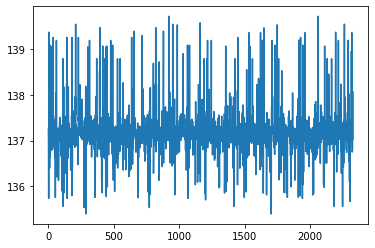

In [41]:
submission_lgbm = pd.DataFrame()
submission_lgbm["time_spent"] = np.expm1(np.mean(y_pred_tot,0))
submission_lgbm["time_spent"].plot()

#CatBoost

In [42]:
X=final_features
y=target

errmain=[]
y_pred_main=[]

#For Stacking
cb_train_res = pd.DataFrame()
cb_test_res = pd.DataFrame()

i=0
from sklearn.model_selection import KFold,StratifiedKFold
fold=KFold(n_splits=4,shuffle=True,random_state=1996)
for train_index, test_index in fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    depth = 5
    rf=CatBoostRegressor(n_estimators=2000,eval_metric='RMSE',learning_rate=0.005,max_depth=depth)
    rf.fit(X_train,y_train,eval_set=[(X_test, y_test.values)],
           verbose=200,
           early_stopping_rounds=50
          )
    pr=rf.predict(X_test)
    print("errmain: ",np.sqrt(mean_squared_log_error(np.expm1(y_test.values),np.expm1(pr))))
    
    errmain.append(np.sqrt(mean_squared_log_error(np.expm1(y_test.values),np.expm1(pr))))
    pp = rf.predict(final_featurest)
    print(pp.shape)
    y_pred_main.append(pp)
    
    cb_train_res["iteration_"+str(i)] = rf.predict(X)
    cb_test_res["iteration_"+str(i)] = rf.predict(final_featurest)
    i=i+1

0:	learn: 1.7631253	test: 1.7697896	best: 1.7697896 (0)	total: 905ms	remaining: 30m 9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.769518096
bestIteration = 87

Shrink model to first 88 iterations.
errmain:  1.7695181046166948
(2327,)
0:	learn: 1.7610683	test: 1.7760092	best: 1.7760092 (0)	total: 474ms	remaining: 15m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.776009164
bestIteration = 0

Shrink model to first 1 iterations.
errmain:  1.7760091735289827
(2327,)
0:	learn: 1.7577749	test: 1.7860616	best: 1.7860616 (0)	total: 456ms	remaining: 15m 12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.785816207
bestIteration = 76

Shrink model to first 77 iterations.
errmain:  1.7858162042842811
(2327,)
0:	learn: 1.7768502	test: 1.7285457	best: 1.7285457 (0)	total: 298ms	remaining: 9m 56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.728535089
bestIteration = 5

Shrink model to first 6 iterations.
err

In [43]:
np.mean(errmain)

1.7649696436801763

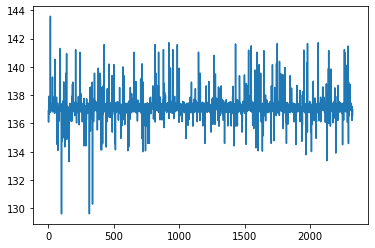

In [45]:
submission_cat = pd.DataFrame()
submission_cat["time_spent"] = np.expm1(np.mean(y_pred_main, 0))
submission_cat["time_spent"].plot()

#XGBoost

In [46]:
y_pred_totxgb=[]
errx=[]
feature_importance_df = pd.DataFrame()

#For Stacking
xgb_train_res = pd.DataFrame()
xgb_test_res = pd.DataFrame()

from sklearn.model_selection import KFold,StratifiedKFold
fold=KFold(n_splits=4,shuffle=True,random_state=1996)
i=1
for train_index, test_index in fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    depth=5
    m=XGBRegressor(n_estimators=350,learning_rate=0.01,max_depth=depth,eval_metric ="rmse")
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=50,verbose=200)
    preds=m.predict(X_test)
    print(f"RMSLE is: {np.sqrt(mean_squared_log_error(np.expm1(y_test), np.expm1(preds)))}")
    errx.append(np.sqrt(mean_squared_log_error(np.expm1(y_test), np.expm1(preds))))
    #print(f"RMSLE is:",rmsle_lgb(y_test, preds))
    #errx.append(rmsle_lgb(y_test, preds))
    p = m.predict(final_featurest)
    y_pred_totxgb.append(p)
    
    xgb_train_res["iteration_"+str(i)] = m.predict(X)
    xgb_test_res["iteration_"+str(i)] = m.predict(final_featurest)
    i+=1

[17:46:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.73402	validation_1-rmse:4.70245
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[200]	validation_0-rmse:1.80768	validation_1-rmse:1.86006
[349]	validation_0-rmse:1.68466	validation_1-rmse:1.78031
RMSLE is: 1.7803142048384506
[17:48:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4.71723	validation_1-rmse:4.75359
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[200]	validation_0-rmse:1.80363	validation_1-rmse:1.89396
[349]	validation_0-rmse:1.68267	validation_1-rmse:1.80405
RMSLE is: 1.8040471519233865
[17:50:26] WARNING: /works

In [47]:
np.mean(errx)

1.7836290653368865

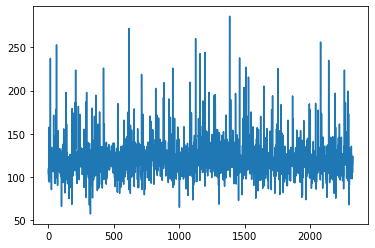

In [48]:
submission_xgb = pd.DataFrame()
submission_xgb["time_spent"] = np.expm1(np.mean(y_pred_totxgb, 0))
submission_xgb["time_spent"].plot()

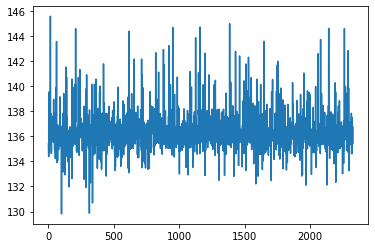

In [49]:
submission = pd.DataFrame()
submission["time_spent"] = submission_cat["time_spent"]*0.5 + submission_lgbm["time_spent"]*0.45 + submission_xgb["time_spent"]*0.05
submission["time_spent"].plot()

In [50]:
submission.to_csv("dec_25_v13_lgbm_50+cb_45+xgb_5.csv",index=False)